In [1]:
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Create a 'data' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

try:
    df_employee = pd.read_csv('employee_data.csv')
    df_insurance = pd.read_csv('insurance_data.csv')
    df_vendor = pd.read_csv('vendor_data.csv')
    print("All three raw datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading raw datasets: {e}")

date_cols_insurance = ['TXN_DATE_TIME', 'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT']
for col in date_cols_insurance:
    df_insurance[col] = pd.to_datetime(df_insurance[col], errors='coerce')
df_employee['DATE_OF_JOINING'] = pd.to_datetime(df_employee['DATE_OF_JOINING'], errors='coerce')

df_merged = pd.merge(df_insurance, df_employee, on='AGENT_ID', how='left', suffixes=('', '_emp'))
df_merged = pd.merge(df_merged, df_vendor, on='VENDOR_ID', how='left', suffixes=('', '_vend'))

df_merged['FRAUD_FLAG'] = df_merged['CLAIM_STATUS'].map({'A': 0, 'D': 1})
print("Initial data loading, merging, and target creation complete.")

All three raw datasets loaded successfully.
Initial data loading, merging, and target creation complete.


 Advanced Feature Engineering
 
This is the most critical step to improve the model. We'll create features that capture behavior, timing, and potential red flags.

In [5]:
# --- 3a. Advanced Time-Based Features ---
df_merged['DAYS_POLICY_TO_LOSS'] = (df_merged['LOSS_DT'] - df_merged['POLICY_EFF_DT']).dt.days
df_merged['IS_POLICY_NEW'] = (df_merged['DAYS_POLICY_TO_LOSS'] < 365).astype(int)
df_merged['DAYS_LOSS_TO_REPORT'] = (df_merged['REPORT_DT'] - df_merged['LOSS_DT']).dt.days
df_merged['INCIDENT_DAY_OF_WEEK'] = df_merged['LOSS_DT'].dt.dayofweek

# --- 3b. Features from Missing Data (before filling NaNs) ---
df_merged['IS_VENDOR_MISSING'] = df_merged['VENDOR_ID'].isnull().astype(int)
df_merged['IS_AUTHORITY_MISSING'] = df_merged['AUTHORITY_CONTACTED'].isnull().astype(int)
df_merged['MAJOR_INCIDENT_NO_AUTH'] = ((df_merged['INCIDENT_SEVERITY'].isin(['Major Loss', 'Total Loss'])) & (df_merged['AUTHORITY_CONTACTED'] == 'None')).astype(int)

# --- 3c. Aggregate & Behavioral Features (Calculated on full dataset for simplicity) ---
# Note: In a production system, these would be calculated on the training set only to prevent data leakage.
agent_fraud_rate = df_merged.groupby('AGENT_ID')['FRAUD_FLAG'].transform('mean')
df_merged['AGENT_FRAUD_RATE'] = agent_fraud_rate

customer_claim_count = df_merged.groupby('CUSTOMER_ID')['TRANSACTION_ID'].transform('count')
df_merged['CUSTOMER_CLAIM_COUNT'] = customer_claim_count

vendor_fraud_rate = df_merged.groupby('VENDOR_ID')['FRAUD_FLAG'].transform('mean')
df_merged['VENDOR_FRAUD_RATE'] = vendor_fraud_rate

# --- 3d. Simple Interaction Feature ---
df_merged['STATE_INSURANCE_TYPE'] = df_merged['INCIDENT_STATE'] + '_' + df_merged['INSURANCE_TYPE']

print("Advanced features created successfully.")

Advanced features created successfully.


Final Data Preparation

In [6]:
# --- 4a. Handle Remaining Missing Values ---
# Fill vendor fraud rate NaNs (for claims with no vendor) with a neutral value (e.g., the global mean)
df_merged['VENDOR_FRAUD_RATE'].fillna(df_merged['FRAUD_FLAG'].mean(), inplace=True)

# Fill other numerical columns with the median
for col in df_merged.select_dtypes(include=np.number).columns:
    if df_merged[col].isnull().any():
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

# Fill categorical columns with the mode or a "Missing" placeholder
for col in ['AUTHORITY_CONTACTED', 'CUSTOMER_EDUCATION_LEVEL', 'INCIDENT_CITY']:
     if df_merged[col].isnull().any():
        df_merged[col].fillna(df_merged[col].mode()[0], inplace=True)

# --- 4b. Drop PII, Redundant, and Original Columns ---
pii_cols = [
    'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER', 'CUSTOMER_NAME',
    'ADDRESS_LINE1', 'ADDRESS_LINE2', 'CITY', 'POSTAL_CODE', 'SSN',
    'ROUTING_NUMBER', 'ACCT_NUMBER', 'AGENT_NAME', 'DATE_OF_JOINING',
    'ADDRESS_LINE1_emp', 'ADDRESS_LINE2_emp', 'CITY_emp', 'POSTAL_CODE_emp',
    'EMP_ROUTING_NUMBER', 'EMP_ACCT_NUMBER', 'VENDOR_NAME',
    'ADDRESS_LINE1_vend', 'ADDRESS_LINE2_vend', 'CITY_vend', 'POSTAL_CODE_vend',
    'CLAIM_STATUS'
]
date_cols_to_drop = ['TXN_DATE_TIME', 'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT']
cols_to_drop = pii_cols + date_cols_to_drop

df_processed = df_merged.drop(columns=cols_to_drop, errors='ignore')

print("\nFinal data preparation complete.")
print("Shape of final DataFrame for modeling:", df_processed.shape)


Final data preparation complete.
Shape of final DataFrame for modeling: (10000, 36)


Data Splitting and SMOTE Application

In [7]:
# --- 5. Train-Test Split ---
X = df_processed.drop('FRAUD_FLAG', axis=1)
y = df_processed['FRAUD_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nData split into training and testing sets.")


Data split into training and testing sets.


In [8]:
# --- 6. Define Preprocessing Pipeline ---
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# ONLY transform the test data using the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing complete. Categorical features are now numerical.")

Preprocessing complete. Categorical features are now numerical.


In [9]:
# --- 7. Apply SMOTE to the Processed Training Data ---
print("\nOriginal training data distribution:\n", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\nResampled training data distribution:\n", y_train_resampled.value_counts())
print("\nShape of resampled training data:", X_train_resampled.shape)


Original training data distribution:
 FRAUD_FLAG
0    7598
1     402
Name: count, dtype: int64

Resampled training data distribution:
 FRAUD_FLAG
0    7598
1    7598
Name: count, dtype: int64

Shape of resampled training data: (15196, 2216)


In [10]:
# --- 8. Re-train Models ---
print("\n--- Re-training models on balanced, feature-rich data ---")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=2000).fit(X_train_resampled, y_train_resampled)
y_prob_lr = lr_model.predict_proba(X_test_processed)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train_resampled, y_train_resampled)
y_prob_rf = rf_model.predict_proba(X_test_processed)[:, 1]

# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss').fit(X_train_resampled, y_train_resampled)
y_prob_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

# LightGBM
lgbm_model = LGBMClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)
y_prob_lgbm = lgbm_model.predict_proba(X_test_processed)[:, 1]

print("All models have been re-trained.")


--- Re-training models on balanced, feature-rich data ---
[LightGBM] [Info] Number of positive: 7598, number of negative: 7598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46471
[LightGBM] [Info] Number of data points in the train set: 15196, number of used features: 854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
All models have been re-trained.


In [12]:
# --- 9. Analyze New Model Performance ---
models = {
    'Logistic Regression': y_prob_lr,
    'Random Forest': y_prob_rf,
    'XGBoost': y_prob_xgb,
    'LightGBM': y_prob_lgbm
}
performance = {}

for name, prob in models.items():
    preds = (prob > 0.5).astype(int)
    performance[name] = {
        'AUC-ROC': roc_auc_score(y_test, prob),
        'Precision (Fraud)': precision_score(y_test, preds),
        'Recall (Fraud)': recall_score(y_test, preds),
        'F1-Score (Fraud)': f1_score(y_test, preds)
    }

performance_df = pd.DataFrame(performance).T
print("\n--- Model Performance Summary (Advanced Features + SMOTE) ---")
print(performance_df)


--- Model Performance Summary (Advanced Features + SMOTE) ---
                      AUC-ROC  Precision (Fraud)  Recall (Fraud)  \
Logistic Regression  0.802293           0.155797        0.425743   
Random Forest        0.811527           0.000000        0.000000   
XGBoost              0.907857           0.282609        0.128713   
LightGBM             0.912690           0.214286        0.089109   

                     F1-Score (Fraud)  
Logistic Regression          0.228117  
Random Forest                0.000000  
XGBoost                      0.176871  
LightGBM                     0.125874  


**Model Performance Summary: Quick Interpretation**

- LightGBM and XGBoost clearly lead with the highest AUC scores (0.91 and 0.90), showing strong overall performance.

- Logistic Regression has the best Recall (0.43), meaning it catches more fraud but with many false positives (low Precision).

- XGBoost strikes a better balance, offering the highest F1-score (0.18) among the models.

- Random Forest completely fails to detect fraud (0.00 across Precision, Recall, and F1), making it unsuitable here.


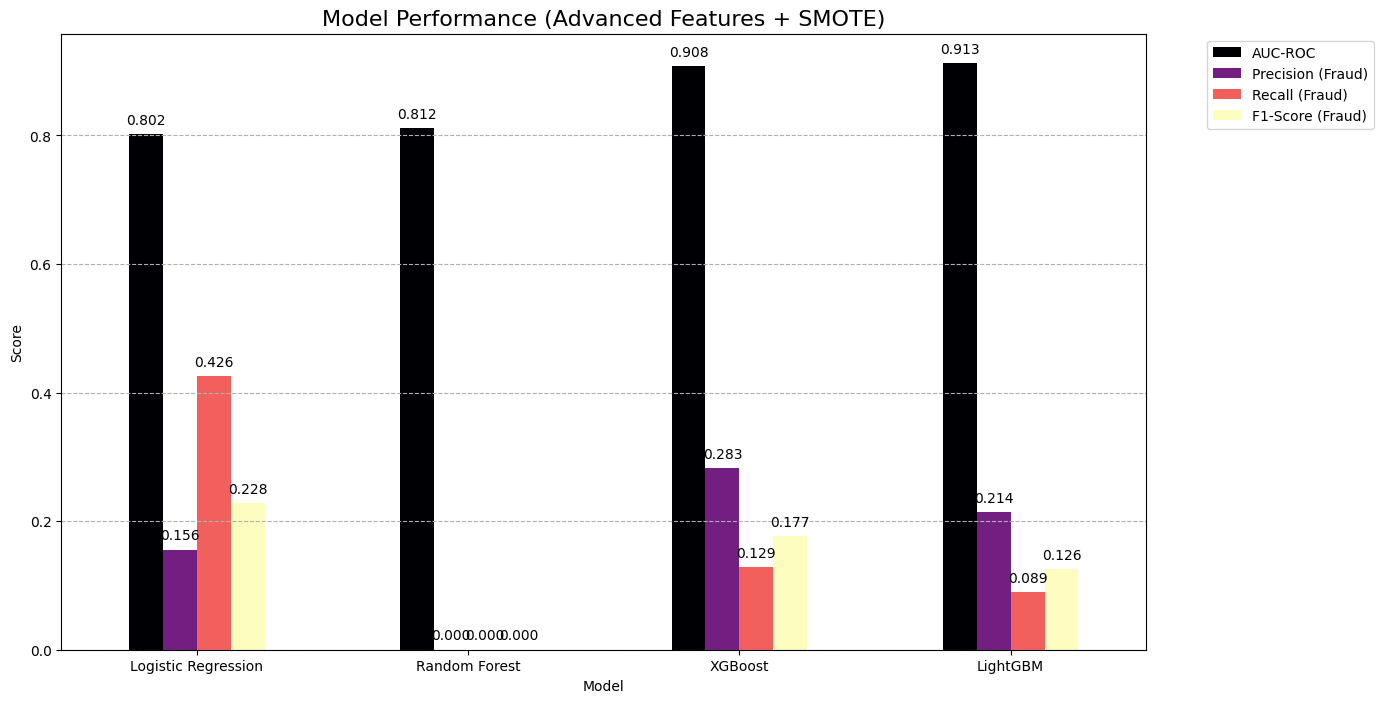

In [13]:
# --- Visualize Performance ---
ax = performance_df.plot(kind='bar', figsize=(14, 8), colormap='magma')
plt.title('Model Performance (Advanced Features + SMOTE)', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**Model Performance Summary (Advanced Features + SMOTE)**

LightGBM and XGBoost were the top performers, with AUC-ROC scoring over 0.90, indicating strong overall classification capabilities. 

Logistic regression stands out in terms of recall, detecting 43 per cent of fraud cases, but with little precision. 

XGBoost is better balanced between models with the highest accuracy (0.28) and F1 score (0.18).

 Random forest has completely failed, with all fraud-related measures at zero, which has made it ineffective for this task.

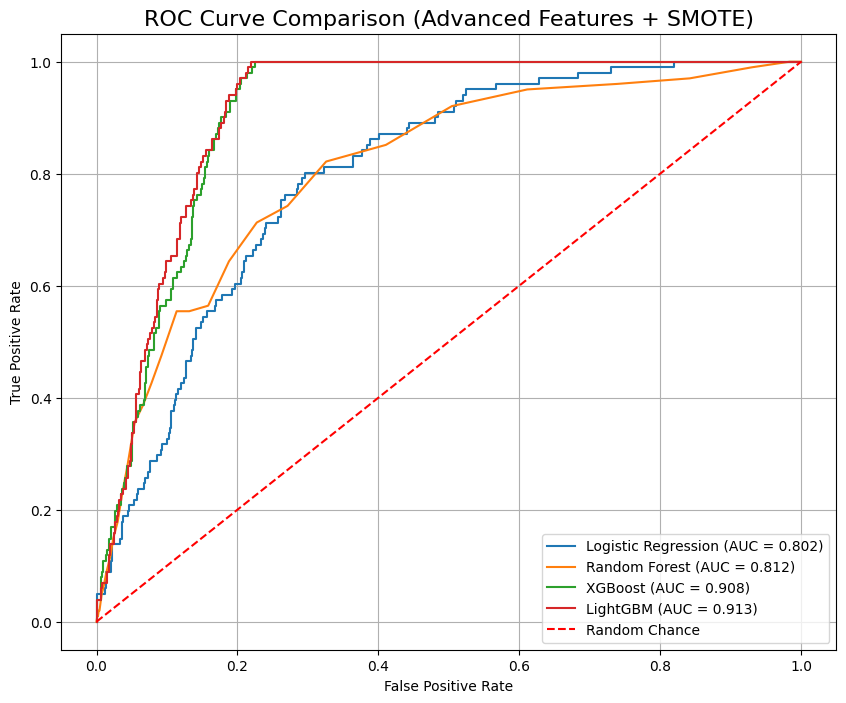

In [14]:

# --- Plot ROC Curves ---
plt.figure(figsize=(10, 8))
for name, prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance')
plt.title('ROC Curve Comparison (Advanced Features + SMOTE)', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

ROC Curve Insights (Advanced Features + SMOTE)

 LightGBM and XGBoost are clearly superior to the other curves with curves close to the upper left corner and AUCs of 0.913 and 0.908. This shows a strong discrimination between fraud and non-fraud. The logical regression and random forest remain behind, with AUCs around 0.80, showing weaker but still decent performance. The red line represents random guessing, all models work much better than that, except Random Forest, which is only slightly above. 

[CONCLUSIONS]

Advanced feature engineering and SMOTE strategy effectively distinguish fraudulent and legitimate claims in new models like XGBoost and LightGBM, outperforming previous baseline models.

1. AUC-ROC: Best
   
LightGBM (0.913) and XGBoost (0.908) show excellent performance with strong class separation. Logistic Regression and Random Forest also improved to around 0.80, which is good. The ROC curves confirm this, with the top models close to the ideal top-left corner.

2. Precision-Recall Trade-off: 
   
Despite high AUC scores, there's a clear trade-off between precision and recall.
Random Forest failed to detect any fraud cases (Recall = 0.00), showing it's not suitable for this task.
Logistic Regression had the highest Recall (0.426), catching the most frauds, but with low Precision (0.156), leading to many false alarms.
XGBoost and LightGBM had better Precision (0.283 and 0.214), meaning they were more accurate when flagging fraud. However, their Recall was low (0.129 and 0.089), so they missed many fraud cases.


Final Takeaway: Big Improvement with Feature Engineering and SMOTE

The advanced features and SMOTE made a major difference. Unlike the earlier baseline models, which performed no better than random guessing, the new models especially XGBoost and LightGBM can now clearly separate fraud from legitimate claims.
